# Variational Inference: Biased Coin Flipping with Pyro and Stable Kumaraswamy Distribution
Author: Max Wasserman, maxw14k@gmail.com

Inspired by this [tutorial](https://www.youtube.com/watch?v=m2erwquF9-4&list=PL7P_RWYU-dL_l6QTqisJwnqlfbQrrhwEi&t=606s).


Choose different variational posterior distributions.
This notebooks shows how to use Variational Inference to fit the posterior distribution of the model of the probability of heads of a biased coin. We compare three different variational distributions: Beta, Kumaraswamy (unstable PyTorch implementation), Kumaraswamy (custom stable implementation)

In [1]:
import pyro
import torch
from pyro.distributions import constraints
from pyro.distributions.torch_distribution import TorchDistributionMixin
import pyro.distributions

from kumaraswamy import KumaraswamyStable

import matplotlib.pyplot as plt
import numpy as np
import time

class KumaraswamyStablePyro(KumaraswamyStable, TorchDistributionMixin):
   pass


In [49]:
def model(x=None):
    
    prob = pyro.sample(
        "prob", 
        pyro.distributions.Uniform(0.0, 1.0)
    )

    with pyro.plate("data", len(x)):
        return pyro.sample(
            "flip", 
            pyro.distributions.Bernoulli(prob), 
            obs=x
            )

def guide_torch_beta(x=None):
    # Define the parameters, their initial values and their constraints.
    log_alpha = pyro.param(
        "log_alpha", 
        torch.tensor(1.0),
        constraint=torch.distributions.constraints.real
    )

    log_beta = pyro.param(
        "log_beta", 
        torch.tensor(1.0), 
        constraint=torch.distributions.constraints.real
    )

    # Sample the latent variable using those parameters.
    prob = pyro.sample(
        "prob", 
        pyro.distributions.Beta(torch.exp(log_alpha), torch.exp(log_beta))
    )

def guide_torch_kumar(x=None):
    # Define the parameters, their initial values and their constraints.
    log_alpha = pyro.param(
        "log_alpha", 
        torch.tensor(1.0), 
        constraint=constraints.real
    )

    log_beta = pyro.param(
        "log_beta", 
        torch.tensor(1.0), 
        constraint=constraints.real
    )

    # Sample the latent variable using those parameters.
    prob = pyro.sample(
        "prob", 
        pyro.distributions.Kumaraswamy(torch.exp(log_alpha), torch.exp(log_beta))
    )

def guide_stable_kumar(x=None):
    # Define the parameters, their initial values and their constraints.
    log_alpha = pyro.param(
        "log_alpha", 
        torch.tensor(1.0), 
        constraint=constraints.real
    )

    log_beta = pyro.param(
        "log_beta", 
        torch.tensor(1.0), 
        constraint=constraints.real
    )

    # Sample the latent variable using those parameters.
    prob = pyro.sample(
        "prob", 
        KumaraswamyStablePyro(log_alpha, log_beta)
    )


In [110]:
## Sample data
torch.manual_seed(0)
true_p = 0.1
num_flips = 100
data = torch.bernoulli(torch.tensor(true_p).expand(num_flips))

## Training hyperparameters
num_iters = 20000
lr = .05

In [114]:
print(f"num heads: {data.sum()}"), print(f"num tails: {num_flips - data.sum()}"), print(f"true p: {true_p}")

num heads: 9.0
num tails: 91.0
true p: 0.1


(None, None, None)

In [115]:
def make_plots(losses, times, params, final_params):
    ave_of_last_losses = np.mean(np.log10(losses)[-10:])
    print(f"Log10 of final loss: {ave_of_last_losses:.4f}")
    plt.plot(np.log10(losses))
    plt.title(f"ELBO: Final {ave_of_last_losses:.4f}")
    plt.xlabel("step")
    plt.ylabel("log10 loss")
    plt.show()

    plt.plot(np.log(times))
    mean_time = np.mean(times[200:])
    stdv_time = np.std(times[200:])
    plt.title(f"Time per step. Mean {mean_time:.4f} s, stdv {stdv_time:.4f} s")
    plt.xlabel("step")
    plt.ylabel("time (log s)")
    plt.show()

    print(f"Learned parameters:")
    log_alpha, log_beta = final_params
    #log_alpha, log_beta = pyro.param("log_alpha"), pyro.param("log_beta")
    print(f"\tlog_alpha = {log_alpha.item():.4f}, log_beta = {log_beta.item():.4f}")
    print(f"\talpha = {torch.exp(log_alpha).item():.4f}, beta = {torch.exp(log_beta).item():.4f}")

    log_alpha_params = [p[0] for p in params]
    log_beta_params = [p[1] for p in params]
    plt.plot(log_alpha_params, label="log_alpha")
    plt.plot(log_beta_params, label="log_beta")
    plt.legend()
    plt.title("Parameter values")
    plt.xlabel("step")
    plt.show()
    
# plotting code to visualize the learned distributions
def plot_learned_dist(dist, num_samples=1000000, true_p=None):
    samples = dist.sample((num_samples,))
    samples_np = samples.cpu().detach().numpy()

    # Plot histogram
    plt.hist(samples_np, bins=20, density=True, alpha=0.6, color='g', label='Histogram')

    # Plot PDF
    x = torch.linspace(0, 1, 1000)
    pdf = torch.exp(dist.log_prob(x))
    plt.plot(x.numpy(), pdf.cpu().detach().numpy(), 'r-', lw=2, label='PDF')
    y_max = pdf[~torch.isnan(pdf)].max().item() + 1
    plt.ylim(0, min(y_max, 20))

    # get ab
    # Plot mean, mode, and variance
    #mean = dist.mean.item()
    #mode = dist.mode.item()
    #variance = dist.variance.item()

    #plt.axvline(mean, color='b', linestyle='--', label=f'Mean: {mean:.2f}')
    #plt.axvline(mode, color='m', linestyle='-.', label=f'Mode: {mode:.2f}')
    #plt.axvline(mean + variance**0.5, color='c', linestyle=':', label=f'Variance: {variance:.2f}')
    #plt.axvline(mean - variance**0.5, color='c', linestyle=':')

    if true_p:
        plt.axvline(true_p, color='k', linestyle='-', label='True p')

    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.title('Histogram of Samples and Analytical PDF from Learned Distribution')
    plt.show()

### Beta

In [116]:
pyro.clear_param_store()
svi = pyro.infer.SVI(model=model,
                     guide=guide_torch_beta,
                     optim=pyro.optim.Adam({"lr": lr}),
                     loss=pyro.infer.Trace_ELBO())

times = []
losses = []
params = []
for step in range(num_iters):
    # record time for step
    start = time.time()
    loss = svi.step(data)
    times.append(time.time() - start)
    params.append((pyro.param("log_alpha").item(), pyro.param("log_beta").item()))
    
    losses.append(loss)
    if step % 100 == 0:
        print('step', step, 'loss', loss, f"log_alpha: {pyro.param('log_alpha').item():.4f},  log_beta {pyro.param('log_beta').item():.4f}")

step 0 loss 97.8252244591713 log_alpha: 0.9500,  log_beta 1.0500
step 100 loss 31.832270622253418 log_alpha: 0.1785,  log_beta 2.4179
step 200 loss 32.44828414916992 log_alpha: 0.6426,  log_beta 2.7609
step 300 loss 34.51546859741211 log_alpha: 0.9823,  log_beta 3.0860
step 400 loss 32.28002166748047 log_alpha: 1.1254,  log_beta 3.2887
step 500 loss 37.25953674316406 log_alpha: 1.4165,  log_beta 3.4130
step 600 loss 32.40236473083496 log_alpha: 1.4933,  log_beta 3.5463
step 700 loss 32.58171844482422 log_alpha: 1.4690,  log_beta 3.8069
step 800 loss 32.95496368408203 log_alpha: 1.7134,  log_beta 3.8756
step 900 loss 32.645198822021484 log_alpha: 1.7730,  log_beta 3.9921
step 1000 loss 33.43473434448242 log_alpha: 1.8708,  log_beta 4.1347
step 1100 loss 32.67376899719238 log_alpha: 1.9648,  log_beta 4.2403
step 1200 loss 32.84442710876465 log_alpha: 2.0665,  log_beta 4.3123
step 1300 loss 33.95005798339844 log_alpha: 2.1535,  log_beta 4.1992
step 1400 loss 33.065120697021484 log_alpha: 

Log10 of final loss: 1.5174


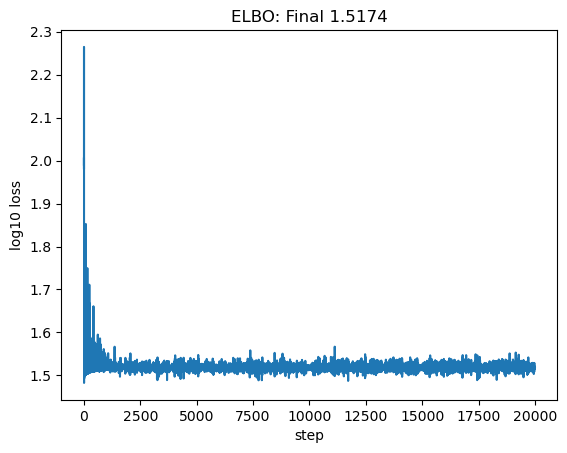

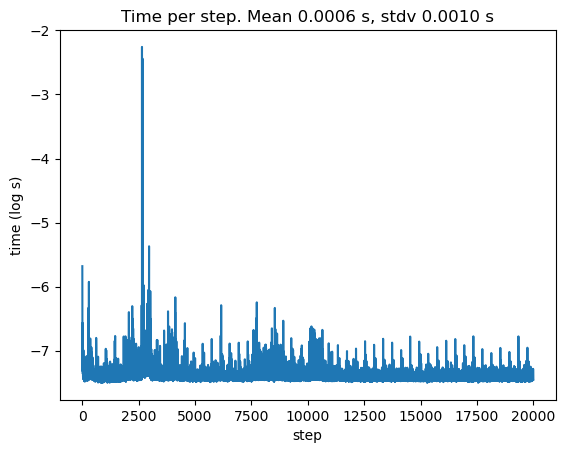

Learned parameters:
	log_alpha = 2.3213, log_beta = 4.5535
	alpha = 10.1893, beta = 94.9596


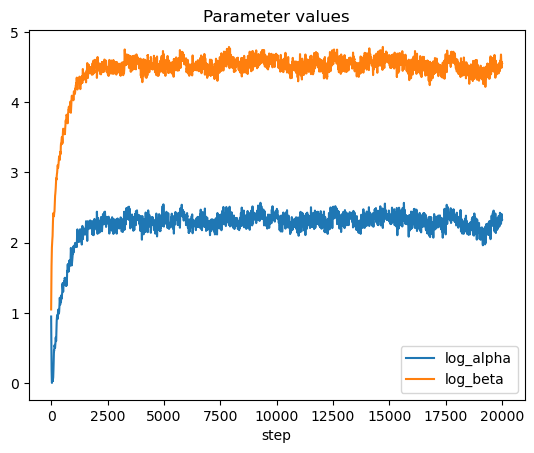

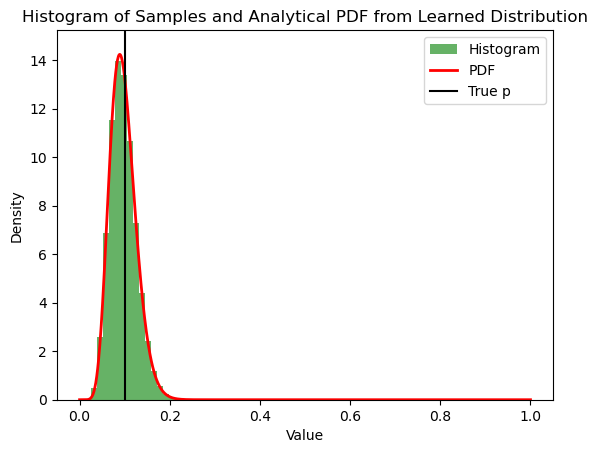

In [117]:
make_plots(losses, times, params, final_params=(pyro.param("log_alpha"), pyro.param("log_beta")))

# plot the learned distribution
dist = torch.distributions.Beta(torch.exp(pyro.param("log_alpha")), torch.exp(pyro.param("log_beta")))
plot_learned_dist(dist, true_p=true_p)

### UNSTABLE Kumaraswamy (PyTorch)

In [118]:
pyro.clear_param_store()
svi = pyro.infer.SVI(model=model,
                     guide=guide_torch_kumar,
                     optim=pyro.optim.Adam({"lr": lr}),
                     #loss=pyro.infer.Trace_ELBO())
                     loss=pyro.infer.TraceMeanField_ELBO())

times = []
losses = []
params = []
for step in range(num_iters):
    start = time.time()
    loss = svi.step(data)
    times.append(time.time() - start)
    losses.append(loss)
    params.append((pyro.param("log_alpha").item(), pyro.param("log_beta").item()))
    if step % 100 == 0:
        print('step', step, 'loss', loss, f"log_alpha: {pyro.param('log_alpha').item():.4f},  log_beta {pyro.param('log_beta').item():.4f}")

step 0 loss 61.356536865234375 log_alpha: 0.9500,  log_beta 1.0500
step 100 loss 37.157711029052734 log_alpha: 0.1360,  log_beta 2.2010
step 200 loss 33.01251983642578 log_alpha: 0.2244,  log_beta 2.9237
step 300 loss 44.040077209472656 log_alpha: 0.4955,  log_beta 3.3380
step 400 loss 33.63238525390625 log_alpha: 0.5279,  log_beta 3.7574
step 500 loss 32.41893005371094 log_alpha: 0.7021,  log_beta 3.8559
step 600 loss 35.746124267578125 log_alpha: 0.6955,  log_beta 4.2656
step 700 loss 32.39868927001953 log_alpha: 0.6887,  log_beta 4.6560
step 800 loss 32.93169403076172 log_alpha: 0.8045,  log_beta 4.8981
step 900 loss 32.41359329223633 log_alpha: 0.8796,  log_beta 5.1833
step 1000 loss 32.91880798339844 log_alpha: 0.9003,  log_beta 5.3880
step 1100 loss 33.085323333740234 log_alpha: 0.9994,  log_beta 5.5976
step 1200 loss 32.67704772949219 log_alpha: 0.9124,  log_beta 5.7833
step 1300 loss 32.46353530883789 log_alpha: 1.0333,  log_beta 5.8442
step 1400 loss 32.4046516418457 log_alpha

/Users/maxw/opt/miniconda3/envs/kumar/lib/python3.9/site-packages/pyro/poutine/trace_struct.py:321: UserWarning: Encountered NaN: log_prob_sum at site 'prob'
  warn_if_nan(
/Users/maxw/opt/miniconda3/envs/kumar/lib/python3.9/site-packages/pyro/infer/trace_elbo.py:158: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")


ValueError: Expected parameter concentration1 (Tensor of shape ()) of distribution Kumaraswamy(concentration1: nan, concentration0: nan) to satisfy the constraint GreaterThan(lower_bound=0.0), but found invalid values:
nan
Trace Shapes:
 Param Sites:
    log_alpha
     log_beta
Sample Sites:

Log10 of final loss: nan


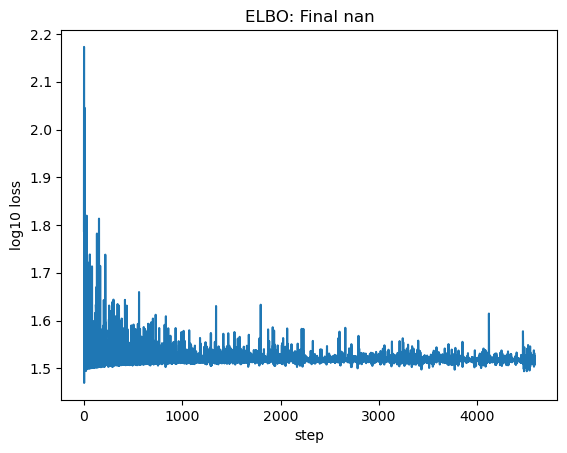

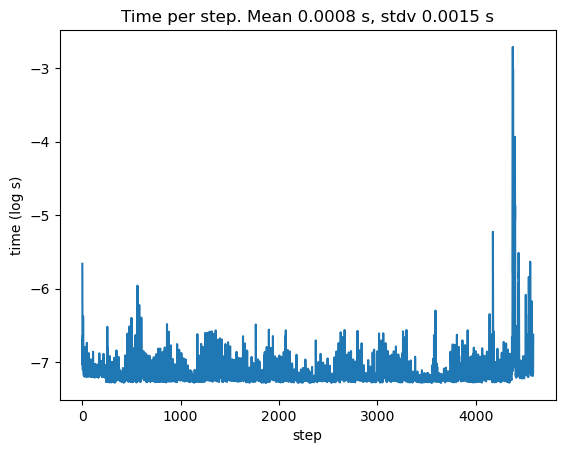

Learned parameters:
	log_alpha = nan, log_beta = nan
	alpha = nan, beta = nan


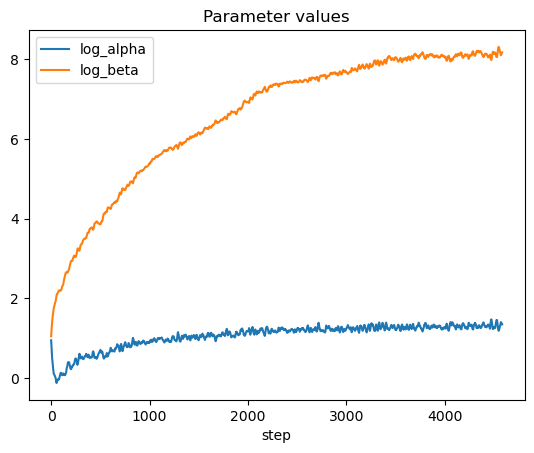

Failed to converge, using last non-nan values: log_alpha 1.3488, log_beta 8.1758


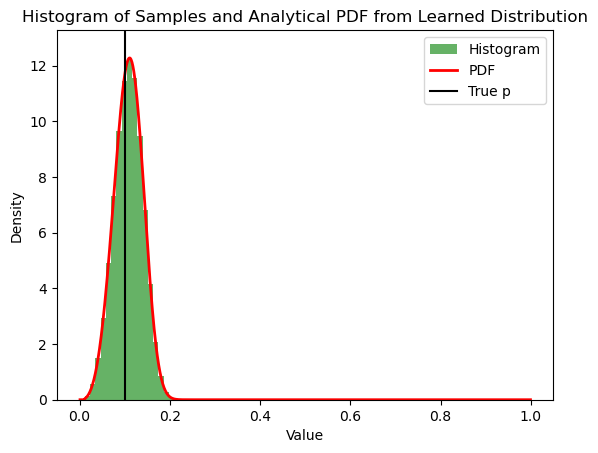

In [119]:
make_plots(losses, times, params, final_params=(pyro.param("log_alpha"), pyro.param("log_beta")))

# did we fail?
log_alpha_params = [p[0] for p in params]
log_beta_params = [p[1] for p in params]
if torch.isnan(torch.tensor(log_alpha_params[-1])) or torch.isnan(torch.tensor(log_beta_params[-1])):
    log_alpha, log_beta = log_alpha_params[-2], log_beta_params[-2]
    print(f"Failed to converge, using last non-nan values: log_alpha {log_alpha:.4f}, log_beta {log_beta:.4f}")

alpha, beta = torch.exp(torch.tensor(log_alpha)), torch.exp(torch.tensor(log_beta))
dist = torch.distributions.Kumaraswamy(alpha, beta)
plot_learned_dist(dist, true_p=true_p)

### STABLE Kumaraswamy

In [120]:
pyro.clear_param_store()
svi = pyro.infer.SVI(model=model,
                     guide=guide_stable_kumar,
                     optim=pyro.optim.Adam({"lr": lr}),
                     #loss=pyro.infer.Trace_ELBO())
                     loss=pyro.infer.TraceMeanField_ELBO()) # uses anlytical KL if available

times = []
losses = []
params = []
for step in range(num_iters):
    start = time.time()
    loss = svi.step(data)
    times.append(time.time() - start)
    params.append((pyro.param("log_alpha").item(), pyro.param("log_beta").item()))
    losses.append(loss)
    if step % 100 == 0:
        print('step', step, 'loss', loss, f"log_alpha: {pyro.param('log_alpha').item():.4f},  log_beta {pyro.param('log_beta').item():.4f}")

step 0 loss 87.98543548583984 log_alpha: 0.9500,  log_beta 1.0500
step 100 loss 39.72487258911133 log_alpha: 0.1679,  log_beta 2.4101
step 200 loss 32.658470153808594 log_alpha: 0.2990,  log_beta 2.9169
step 300 loss 33.52399444580078 log_alpha: 0.4821,  log_beta 3.2711
step 400 loss 35.30266189575195 log_alpha: 0.4816,  log_beta 3.6119
step 500 loss 33.84420394897461 log_alpha: 0.6539,  log_beta 3.8924
step 600 loss 32.7535285949707 log_alpha: 0.6376,  log_beta 4.1401
step 700 loss 32.56250762939453 log_alpha: 0.7203,  log_beta 4.3480
step 800 loss 32.46564865112305 log_alpha: 0.7902,  log_beta 4.6128
step 900 loss 32.389469146728516 log_alpha: 0.7264,  log_beta 4.9762
step 1000 loss 32.64078140258789 log_alpha: 0.9166,  log_beta 5.0957
step 1100 loss 32.29927444458008 log_alpha: 1.0101,  log_beta 5.3004
step 1200 loss 33.04473114013672 log_alpha: 0.9149,  log_beta 5.4882
step 1300 loss 32.305702209472656 log_alpha: 0.9941,  log_beta 5.5897
step 1400 loss 32.37120819091797 log_alpha: 

Log10 of final loss: 1.5185


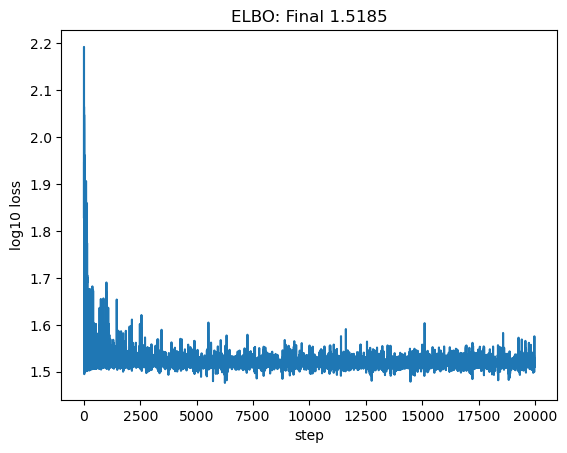

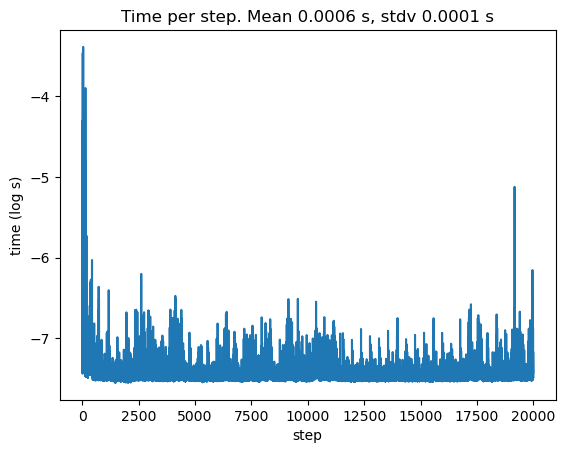

Learned parameters:
	log_alpha = 1.3744, log_beta = 8.9098
	alpha = 3.9527, beta = 7403.9932


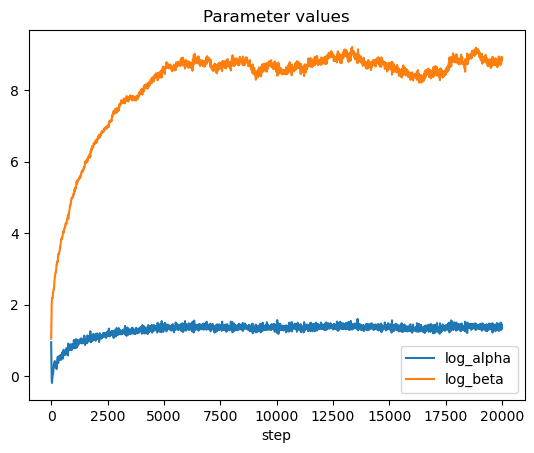

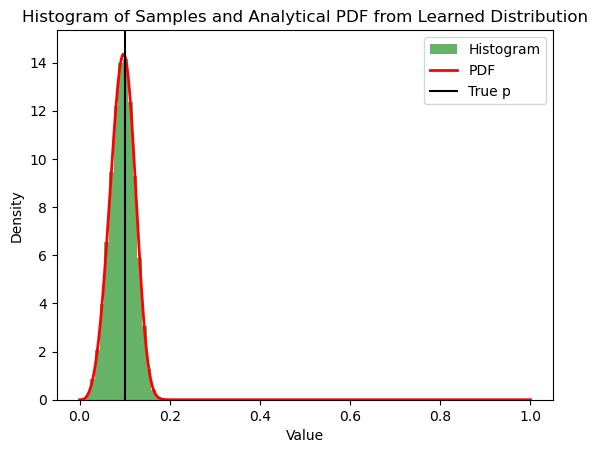

In [121]:
make_plots(losses, times, params, final_params=(pyro.param("log_alpha"), pyro.param("log_beta")))
dist = KumaraswamyStablePyro(pyro.param("log_alpha"), pyro.param("log_beta"))
plot_learned_dist(dist, true_p=true_p)